In [1]:
import sys
sys.path.append("..")
%cd ..

c:\Users\frede\OneDrive - Danmarks Tekniske Universitet\DTU\6. Semester\Bachelor2021-1


In [91]:
from DataPrep.ImportData import importer
from Modelling import modelling
import keras
from keras import Sequential, Model
from keras.layers import Dense, LSTM, Dropout, Input, Reshape
import pyforest
import torch
from tensorflow.keras import regularizers
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from DataPrep.LagCreation import lags
from sklearn.model_selection import train_test_split
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [24]:
m = modelling()
df = m.df.drop(columns=["Charging Time (mins)", "Total Duration (mins)", "Port Number"])

In [25]:
df["Label"] = df["Label"] + 1

In [143]:
y = df[["Energy (kWh)","Start Date", "Label"]].set_index("Start Date",drop=False).resample("d").min()
X = lags().buildLaggedFeatures(y[["Energy (kWh)", "Label"]], ["Energy (kWh)"],5, dropna=False)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, shuffle=True)
#X_train=X_train.drop(columns="lag_0")
#X_test=X_test.drop(columns="lag_0")
y_train = y_train.set_index("Start Date",drop=False)
y_test = y_test.set_index("Start Date",drop=False)

y_train.freq= "D"
#y_train = y_train.resample("d").min()
#y_test = y_test.resample("d").min()
#y_train["Energy (kWh)"]  = y_train["Energy (kWh)"].fillna(0)
#y_test["Energy (kWh)"]  = y_test["Energy (kWh)"].fillna(0)

array([1., 3., 2.])

In [140]:
X_train = X_train.fillna(0)
X_test = X_test.fillna(0)

In [141]:
y_train = y_train.drop(columns="Start Date")
y_test = y_test.drop(columns="Start Date")
y_train = y_train.drop(columns="Label")
y_test = y_test.drop(columns="Label")

X_train = X_train.drop(columns="Energy (kWh)")
X_test = X_test.drop(columns="Energy (kWh)")

In [75]:
labels = df.Label.unique()

array([1., 2., 3., 4., 5., 6., 7., 8.])

In [93]:
stackings_X_test = []
stackings_X_train = []
#stackings_X_val = []
stackings_y_test = []
stackings_y_train = []
#stackings_y_val = []
for l in labels:
    stackings_X_test.append(tf.ragged.constant(X_test[X_test.Label == l]))
    stackings_y_test.append((tf.ragged.constant(y_test["Energy (kWh)"][X_test.Label == l])))
    stackings_X_train.append((tf.ragged.constant(X_train[X_train.Label == l])))
    stackings_y_train.append((tf.ragged.constant(y_train["Energy (kWh)"][X_train.Label == l])))
#    stackings_X_val.append((tf.ragged.constant(X_val[X_val.Label == l])))
#    stackings_y_val.append((tf.ragged.constant(y_val[X_val.Label == l])))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [66]:
df.isna().sum().sum()

17087

In [94]:
X_train_stack = tf.ragged.stack(stackings_X_train).to_tensor()
X_test_stack =  tf.ragged.stack(stackings_X_test).to_tensor()
#X_val_stack =tf.ragged.stack(stackings_X_val).to_tensor()
y_train_stack = tf.ragged.stack(stackings_y_train).to_tensor()
y_test_stack = tf.ragged.stack(stackings_y_test).to_tensor()
#y_val_stack = tf.ragged.stack(stackings_y_val).to_tensor()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [108]:
yl = []
xl = []
for i in range(8):
    yl.append(y_train_stack[i])

In [126]:
X_train
#len(np.array(yl).reshape(-1,1))

,Label,Energy (kWh)_lag1,Energy (kWh)_lag2,Energy (kWh)_lag3,Energy (kWh)_lag4,Energy (kWh)_lag5
Start Date,,,,,,
2017-05-06,7.0,2.283154,2.529432,2.418891,2.354427,2.621636
2015-08-14,2.0,2.955163,2.139172,2.443101,2.582598,3.061705
2012-08-02,2.0,1.678865,1.131619,1.495169,1.856129,1.585233
2016-07-22,7.0,2.201256,2.115952,2.177956,2.320012,2.439520
2015-11-04,3.0,1.559470,2.517077,1.447230,1.485799,2.102999
...,...,...,...,...,...,...
2015-11-20,5.0,1.831516,2.021344,1.931895,1.920674,2.126489
2017-09-30,5.0,1.808625,3.098100,1.719847,1.694712,2.700528
2018-03-11,2.0,3.408008,3.243627,2.914942,2.755358,2.802372


In [142]:
sam = SARIMAX(y_train,exog=X_train, order=(5,1,5), trend="n", freq="D")
sam_fit = sam.fit(method="lbfgs")
print(sam_fit.summary())

ValueError: The indices for endog and exog are not aligned

c:\Users\frede\OneDrive - Danmarks Tekniske Universitet\DTU\6. Semester\Bachelor2021-1\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

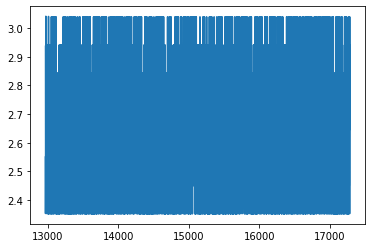

In [132]:
n=len(y_test)
y_pred = sam_fit.forecast(steps = n, exog=X_test.fillna(0))
#plt.plot(y_test)
plt.plot(y_pred)
plt.show()